In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, ExpSineSquared, DotProduct

# Example of GP using simulated data

Here we investigate a simulated dataset using sine waves to demonstrate something that looks like a stationary time-series with some noise.

We demonstrate two scenarios:  
1) Noise-free labels  
2) Some noise

In [3]:
# SIMULATED DATA 

# This is the true unknown function we are trying to approximate
def f(x):  
    return np.sin(x)**2 + np.random.normal(scale=1, size=x.shape)

## 1) Noise-free labels

In [4]:
xpts = np.arange(-3, 3, step=0.01) 

ypts = f(xpts)

x_many = np.random.uniform(low=-3, high=3, size=10)

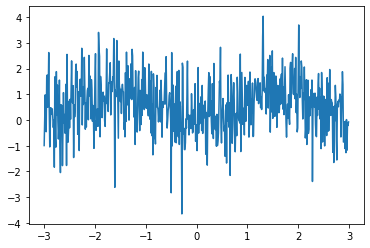

In [5]:
plt.plot(xpts, ypts)
plt.show()

This is how the "true" function looks like, but in practice we obviously do not know this. Fortunately, this does not matter for GP's!

### a) Sampling from the prior

To demonstrate how the GP works, we will consider the initial setting where we have no observations whatsoever, and we simply sample from our Gaussian process prior.  


We implement the RBF kernel for our covariance matrix, and use hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

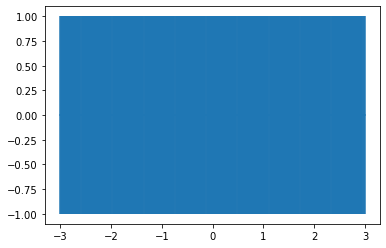

In [6]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

theta = [1, 10]
sigma_0 = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)
plt.show()

Given that we have no observations yet, we can observe equal uncertainty for our entire range of x values as expected.   
**Let's see what happens when we observe some "real" data.**

In [6]:
x_observations = np.atleast_2d([-2., -0.2, 3.]).T
y_observations = f(x_observations).ravel()

In [7]:
# We instantiate the GP sklearn model
model = gaussian_process.GaussianProcessRegressor()

In [8]:
# We fit the GP to our observed data
model.fit(np.array(x_observations).reshape(-1, 1), np.array(y_observations))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [9]:
# we predict on the entire x-range defined earlier
y_pred, sigmas = model.predict(xpts.reshape(-1, 1), return_std=True)

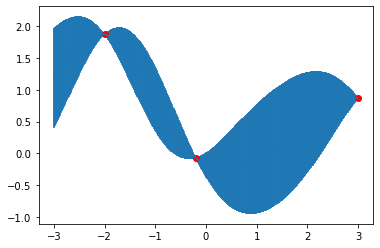

In [10]:
# We plot the observations
plt.errorbar(xpts, y_pred, yerr=sigmas, capsize=0)
plt.plot(x_observations, y_observations, "ro")
plt.show()

**Note how our confidence bands have been updated for these observations?**  

**KEY**: We are constraining the Gaussian process distribution to make functions, that intersect these data points, more probable. This is reflected in an adjustment to the mean and standard deviation of the predicted function.  

As we would expect, the uncertainty of the prediction is small in regions close to the training data and grows as we move further away from those points.


**Let's see how flexible our kernel function can get by combining the ExpSineSquared and RBF Kernel for 25 randomly sampled observations**

In [11]:
# We sample 25 points uniformly
N = 25
x_observations = np.atleast_2d(list(np.random.uniform(-2, 2, size=(N,1))))
y_observations = f(x_observations).ravel()

In [12]:
kernel = RBF(length_scale=0.5) +  ExpSineSquared(length_scale=1) 

model = gaussian_process.GaussianProcessRegressor(alpha=0.15,
                              optimizer=None, kernel=kernel) 

model.fit(np.array(x_observations).reshape(-1, 1), np.array(y_observations))

GaussianProcessRegressor(alpha=0.15, copy_X_train=True,
                         kernel=RBF(length_scale=0.5) + ExpSineSquared(length_scale=1, periodicity=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer=None, random_state=None)

In [13]:
y_pred, sigmas = model.predict(xpts.reshape(-1, 1), return_std=True)

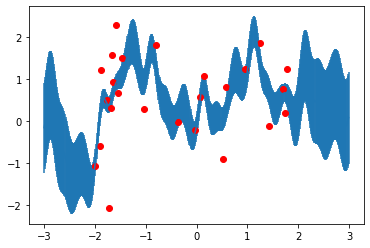

In [14]:
#plt.figure(figsize=(10,8))
plt.errorbar(xpts, y_pred.ravel(), yerr=sigmas, capsize=0)
plt.plot(x_observations.ravel(), y_observations, "ro")
plt.show()

## 2) Noisy-labels

### Kernel for noisy observations
- If a training point is reacquired we still expect variance (think of this like the distance is not really zero)
- In essence simply just add something to the diagonal of the kernel matrix
$$\mathbf{K}=\mathbf{K}_\text{SE}+\sigma^2_n \mathbf{I} $$

We will not show the results here, but to add noise to the diagonal we can use the following code:

```python
kernel = RBF(length_scale=0.5) +  ExpSineSquared(length_scale=1) + WhiteKernel(noise=0.1)
```

In [ ]:
# Additional resources
# https://blog.dominodatalab.com/fitting-gaussian-process-models-python/
# https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb
# https://medium.com/panoramic/gaussian-processes-for-little-data-2501518964e4